<a href="https://colab.research.google.com/github/enricco000/MR4010.10/blob/main/Actividad_4_1_Clasificacion_Keras_Equipo19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importación de librerías estándar
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# El dataset está en mi google drive. Para correr este notebook, debes subir tu
# dataset a google drive también. En la entrega anterior, utilizamos el juego
# de datos en este repositorio:
# https://github.com/RashadGarayev/PersonDetection
# Para poder accederlo desde este notebook
# necesitamos importar drive
from google.colab import drive
drive.mount('/content/gdrive')
# Definimos la ruta de la carpeta donde se encuentran las imágenes
PWD = '/content/gdrive/MyDrive/DATAIMAGE'
# Definimos las rutas de las subcarpetas de los ejemplos etiquetados 
POSITIVE = os.path.join(PWD, 'positive')
NEGATIVE = os.path.join(PWD, 'negative')

Mounted at /content/gdrive


In [2]:
# Función para revisar imágenes al azar dentro de los folders. El objetivo
# es corroborar que estamos en la ruta correcta y que tenemos imágenes
# que corresponden con la etiqueta (positivo o negativo)

def draw_random_sample(folder_path, sample_size=5):
    # Lista de las imágenes en el folder
    image_files = [file for file in os.listdir(folder_path) if file.endswith(
        ('.jpg', '.jpeg', '.png'))
    ]

    # Revisa si hay suficientes imágenes. Nosotros queremos 5
    if len(image_files) < sample_size:
        print("No hay suficientes imágenes en la carpeta")
        return

    # Selecciona una muestra al azar
    selected_images = random.sample(image_files, sample_size)

    # Mostramos las imágenes con PIL
    for random_img in selected_images:
      image = Image.open(os.path.join(folder_path, random_img))

      # Display the image
      display(image)
    return

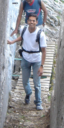

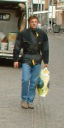

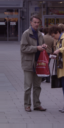

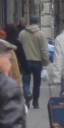

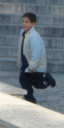

In [3]:
# Veamos 5 imágenes al azar del folder de positivos
draw_random_sample(POSITIVE)

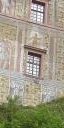

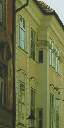

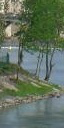

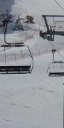

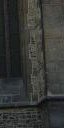

In [4]:
# Ahora del folder de negativos
draw_random_sample(NEGATIVE)

Epoch 1/50
165/165 [==============================] - 12s 11ms/step - loss: 0.4778 - accuracy: 0.7878 - val_loss: 0.3327 - val_accuracy: 0.8545
Epoch 2/50
165/165 [==============================] - 1s 8ms/step - loss: 0.2923 - accuracy: 0.8838 - val_loss: 0.6100 - val_accuracy: 0.7700
Epoch 3/50
165/165 [==============================] - 1s 8ms/step - loss: 0.2371 - accuracy: 0.9099 - val_loss: 0.1378 - val_accuracy: 0.9429
Epoch 4/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1854 - accuracy: 0.9312 - val_loss: 0.1426 - val_accuracy: 0.9505
Epoch 5/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1558 - accuracy: 0.9406 - val_loss: 0.1271 - val_accuracy: 0.9467
Epoch 6/50
165/165 [==============================] - 2s 9ms/step - loss: 0.1327 - accuracy: 0.9533 - val_loss: 0.1224 - val_accuracy: 0.9528
Epoch 7/50
165/165 [==============================] - 2s 9ms/step - loss: 0.1133 - accuracy: 0.9575 - val_loss: 0.0977 - val_accuracy: 0.9596
Epoc

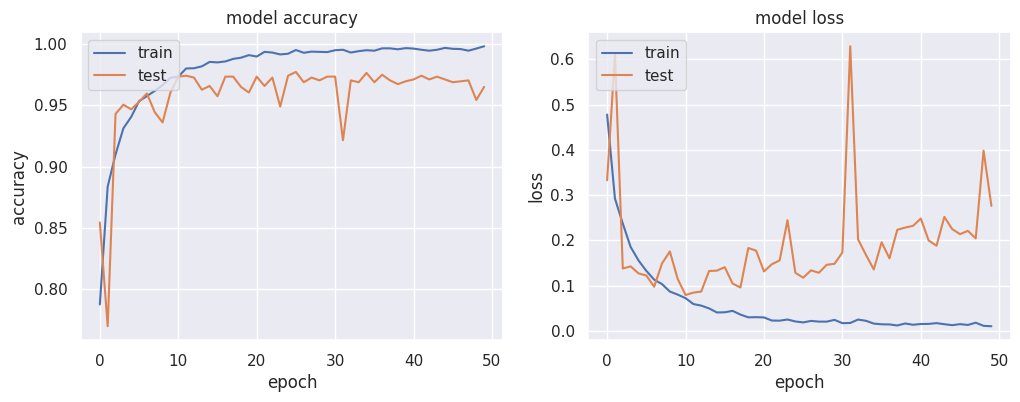

Epoch 1/50
165/165 [==============================] - 4s 12ms/step - loss: 0.4831 - accuracy: 0.7849 - val_loss: 0.5512 - val_accuracy: 0.6664
Epoch 2/50
165/165 [==============================] - 1s 9ms/step - loss: 0.2838 - accuracy: 0.8857 - val_loss: 0.2262 - val_accuracy: 0.9071
Epoch 3/50
165/165 [==============================] - 1s 9ms/step - loss: 0.2256 - accuracy: 0.9150 - val_loss: 0.2926 - val_accuracy: 0.8964
Epoch 4/50
165/165 [==============================] - 2s 10ms/step - loss: 0.1923 - accuracy: 0.9253 - val_loss: 0.1950 - val_accuracy: 0.9162
Epoch 5/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1691 - accuracy: 0.9390 - val_loss: 0.1635 - val_accuracy: 0.9368
Epoch 6/50
165/165 [==============================] - 2s 9ms/step - loss: 0.1433 - accuracy: 0.9486 - val_loss: 0.2479 - val_accuracy: 0.9132
Epoch 7/50
165/165 [==============================] - 2s 10ms/step - loss: 0.1237 - accuracy: 0.9548 - val_loss: 0.1514 - val_accuracy: 0.9444
Epo

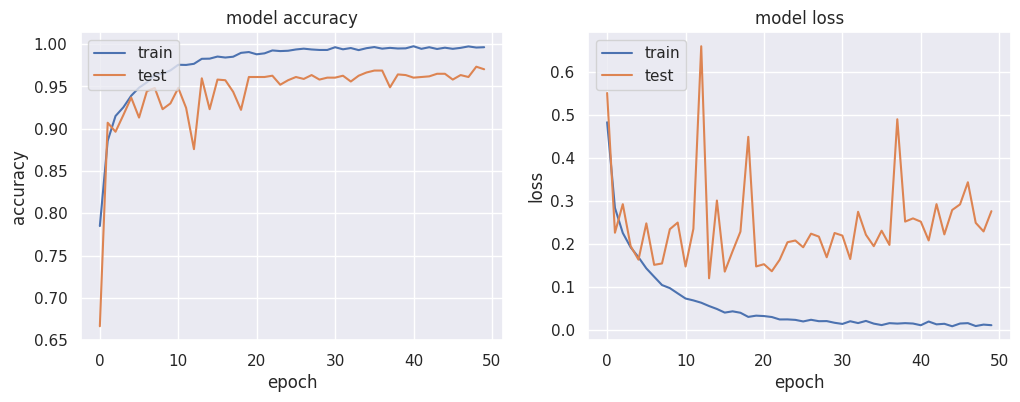

Epoch 1/50
165/165 [==============================] - 4s 15ms/step - loss: 0.4712 - accuracy: 0.7846 - val_loss: 0.4008 - val_accuracy: 0.8224
Epoch 2/50
165/165 [==============================] - 2s 10ms/step - loss: 0.2872 - accuracy: 0.8832 - val_loss: 0.2425 - val_accuracy: 0.8963
Epoch 3/50
165/165 [==============================] - 1s 8ms/step - loss: 0.2261 - accuracy: 0.9118 - val_loss: 0.1821 - val_accuracy: 0.9253
Epoch 4/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1761 - accuracy: 0.9284 - val_loss: 0.1814 - val_accuracy: 0.9352
Epoch 5/50
165/165 [==============================] - 1s 9ms/step - loss: 0.1559 - accuracy: 0.9438 - val_loss: 0.2321 - val_accuracy: 0.9230
Epoch 6/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1308 - accuracy: 0.9520 - val_loss: 0.3854 - val_accuracy: 0.8857
Epoch 7/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1122 - accuracy: 0.9587 - val_loss: 0.1415 - val_accuracy: 0.9482
Epoc

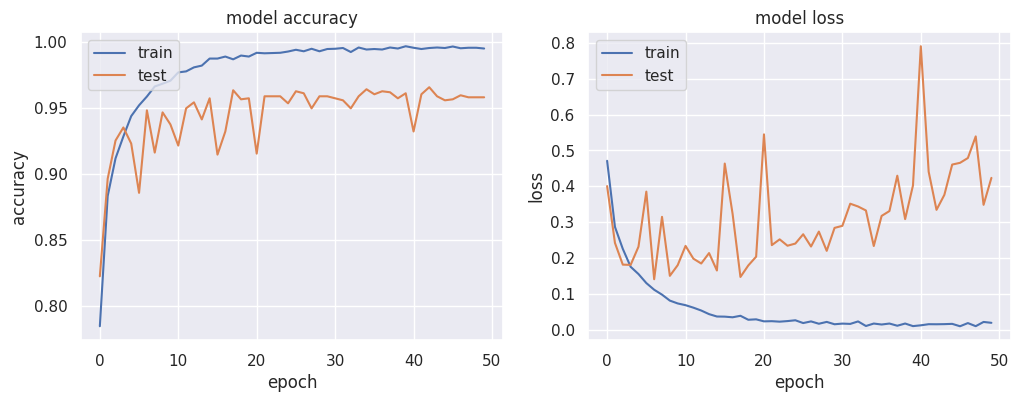

Epoch 1/50
165/165 [==============================] - 3s 11ms/step - loss: 0.4732 - accuracy: 0.7825 - val_loss: 0.2404 - val_accuracy: 0.9276
Epoch 2/50
165/165 [==============================] - 1s 9ms/step - loss: 0.2793 - accuracy: 0.8941 - val_loss: 0.2896 - val_accuracy: 0.8880
Epoch 3/50
165/165 [==============================] - 2s 10ms/step - loss: 0.2263 - accuracy: 0.9120 - val_loss: 0.2119 - val_accuracy: 0.9223
Epoch 4/50
165/165 [==============================] - 2s 9ms/step - loss: 0.1919 - accuracy: 0.9265 - val_loss: 0.1553 - val_accuracy: 0.9383
Epoch 5/50
165/165 [==============================] - 2s 11ms/step - loss: 0.1571 - accuracy: 0.9404 - val_loss: 0.1950 - val_accuracy: 0.9230
Epoch 6/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1361 - accuracy: 0.9488 - val_loss: 0.1776 - val_accuracy: 0.9383
Epoch 7/50
165/165 [==============================] - 1s 9ms/step - loss: 0.1177 - accuracy: 0.9583 - val_loss: 0.1333 - val_accuracy: 0.9482
Epo

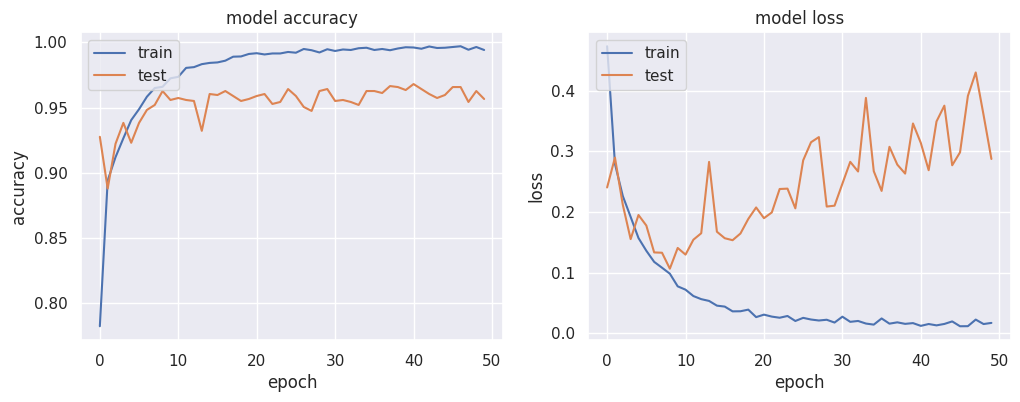

Epoch 1/50
165/165 [==============================] - 3s 11ms/step - loss: 0.4304 - accuracy: 0.8114 - val_loss: 0.2545 - val_accuracy: 0.9093
Epoch 2/50
165/165 [==============================] - 1s 9ms/step - loss: 0.2478 - accuracy: 0.9070 - val_loss: 0.2959 - val_accuracy: 0.8948
Epoch 3/50
165/165 [==============================] - 1s 8ms/step - loss: 0.1966 - accuracy: 0.9267 - val_loss: 0.5771 - val_accuracy: 0.8034
Epoch 4/50
165/165 [==============================] - 1s 9ms/step - loss: 0.1657 - accuracy: 0.9413 - val_loss: 0.1469 - val_accuracy: 0.9413
Epoch 5/50
165/165 [==============================] - 1s 9ms/step - loss: 0.1317 - accuracy: 0.9514 - val_loss: 0.1632 - val_accuracy: 0.9451
Epoch 6/50
165/165 [==============================] - 2s 10ms/step - loss: 0.1116 - accuracy: 0.9564 - val_loss: 0.1310 - val_accuracy: 0.9428
Epoch 7/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0926 - accuracy: 0.9686 - val_loss: 0.1177 - val_accuracy: 0.9566
Epo

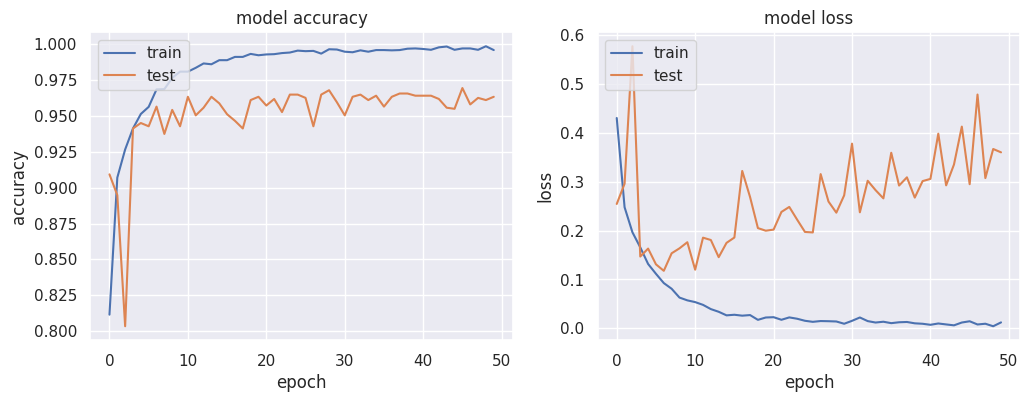

96.27% (+/- 0.49%)


In [9]:
# Dado que todo se ve correcto, podemos avanzar.
# Vamos a hacer un primer intento y construir la red neuronal para detectar
# a los peatones.

# Primero, vamos a hacer una pequeña función de pre-procesamiento de las
# imágenes

def load_and_process_image(image_path):
    # Ruta
    img = Image.open(image_path)

    # Reescalar y convertir a RGB
    img = img.resize((128, 64))
    img = img.convert('RGB')

    # Convertir a arreglo de numpy y normalizar
    img_array = np.array(img) / 255.0

    return img_array

# Importamos las librerías de tensorflow y keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold

# Parámetros
img_width, img_height = 64, 128
batch_size = 32
epochs = 50

# Cargas imágenes y etiquetas
images = []
labels = []

for filename in os.listdir(POSITIVE):
    images.append(load_and_process_image(os.path.join(POSITIVE, filename)))
    labels.append(1)  # peatón

for filename in os.listdir(NEGATIVE):
    images.append(load_and_process_image(os.path.join(NEGATIVE, filename)))
    labels.append(0)  # no peatón

images = np.array(images)
labels = np.array(labels)

# Como primera aproximación, vamos a definir un modelo muy sencilo de
# redes neuronales convolucionales (CNN, por sus siglas en inglés)
def create_model():
    model = Sequential()
    # Primera capa: relu. La entrada de esta capa corresponde con el tamaño
    # de nuestras imágenes
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

# Validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

for train, test in kfold.split(images, labels):
    model = create_model()
    history = model.fit(images[train], labels[train], 
                        validation_data=(images[test], labels[test]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

    # Evaluación del modelo
    scores = model.evaluate(images[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

    # Generación de gráfico de accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # Graficamos también la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))